# Kaggle Titanic: 2 - Data Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import ks_2samp, gaussian_kde

import missingno as msno

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_auc_score,
                             roc_curve)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Add the "src" directory to the system path
project_root  = os.path.abspath('../')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import EnvironmentInfo, PathManager
from src.project_specific import create_data_dictionnary_df, DataOverview, run_dm_pipeline


## Working Environment

### Variables & Paths

In [2]:
path_manager = PathManager(dataset_name="titanic")
print("\n" + str(path_manager))

DATASET_PATH = path_manager.dataset_path
WORKING_PATH = path_manager.working_path

print(f"\nDATASET_PATH: {DATASET_PATH}")
print(f"WORKING_PATH: {WORKING_PATH}")

Running on local.
Dataset directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

Dataset Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

DATASET_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
WORKING_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working


### Datasets

In [3]:
test = pd.read_csv(os.path.join(DATASET_PATH, "test.csv"))
train = pd.read_csv(os.path.join(DATASET_PATH, "train.csv"))

datasets_dict = {
    "train": train,
    "test": test
}

test_memory = test.memory_usage(deep=True).sum()
train_memory = train.memory_usage(deep=True).sum()
print(f"Test dataset memory usage: {test_memory / (1024**2):.2f} MB")
print(f"Train dataset memory usage: {train_memory / (1024**2):.2f} MB")

Test dataset memory usage: 0.13 MB
Train dataset memory usage: 0.28 MB


## Data Management

In [4]:
result = run_dm_pipeline(test, train)

categorical_features = result["categorical_features"]
numerical_features = result["numerical_features"]
target = result["target"]

Target Variable: Survived
Target Variable 'Survived' not found in DataFrame test.
'Embarked' is S for passenger at index 152. Imputing 'Fare' with median fare 8.05 for 'Pclass' 3 and 'Embarked' S.
Remaining missing 'Fare' values in test dataset: 0
Remaining missing 'Embarked' values in train dataset: 0
Remaining missing 'Age' values in the combined dataset: 0

Categorical_features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck', 'Is_Alone', 'AgeGroup']
Numerical features: ['Family_Size', 'LogFare']
target: Survived


In [5]:
test_df = result["test"][categorical_features + numerical_features]
train_df = result["train"][categorical_features + numerical_features + [target]]

## Bivariate Analysis vs Target

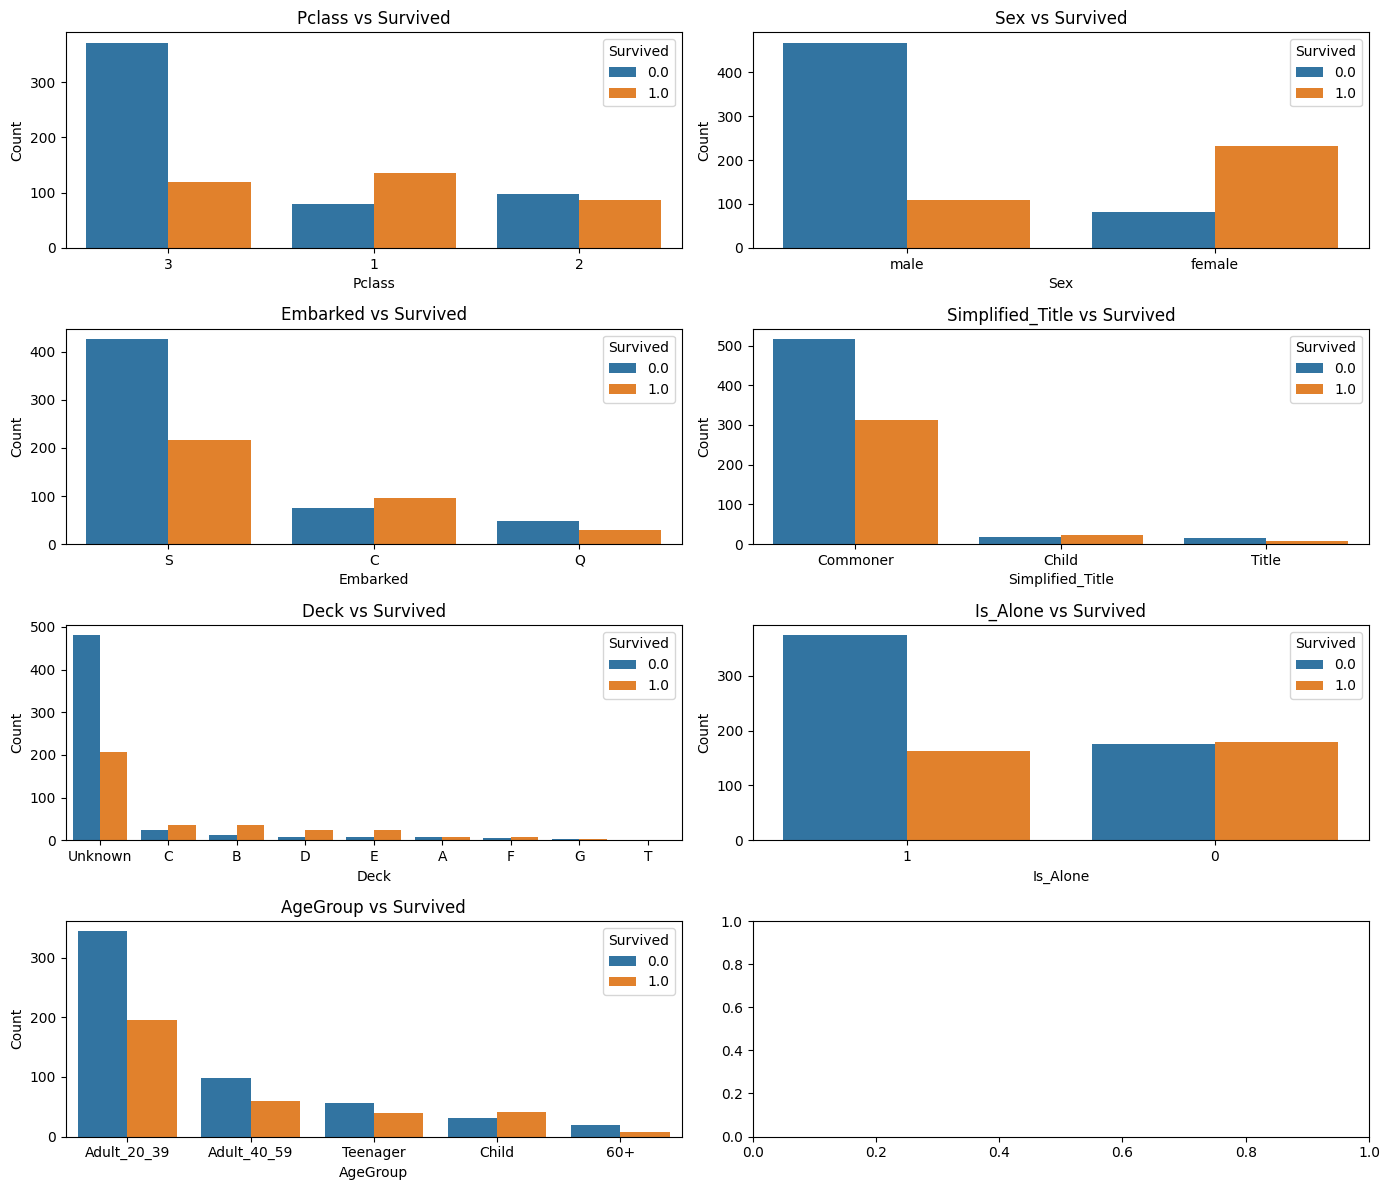

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))

axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    sns.countplot(
        data=train_df,
        x=feature,
        hue=target,
        order=train_df[feature].value_counts().index,
        ax=axes[i]
    )
    axes[i].set_title(f"{feature} vs {target}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].legend(title=target)

plt.tight_layout()
plt.show()

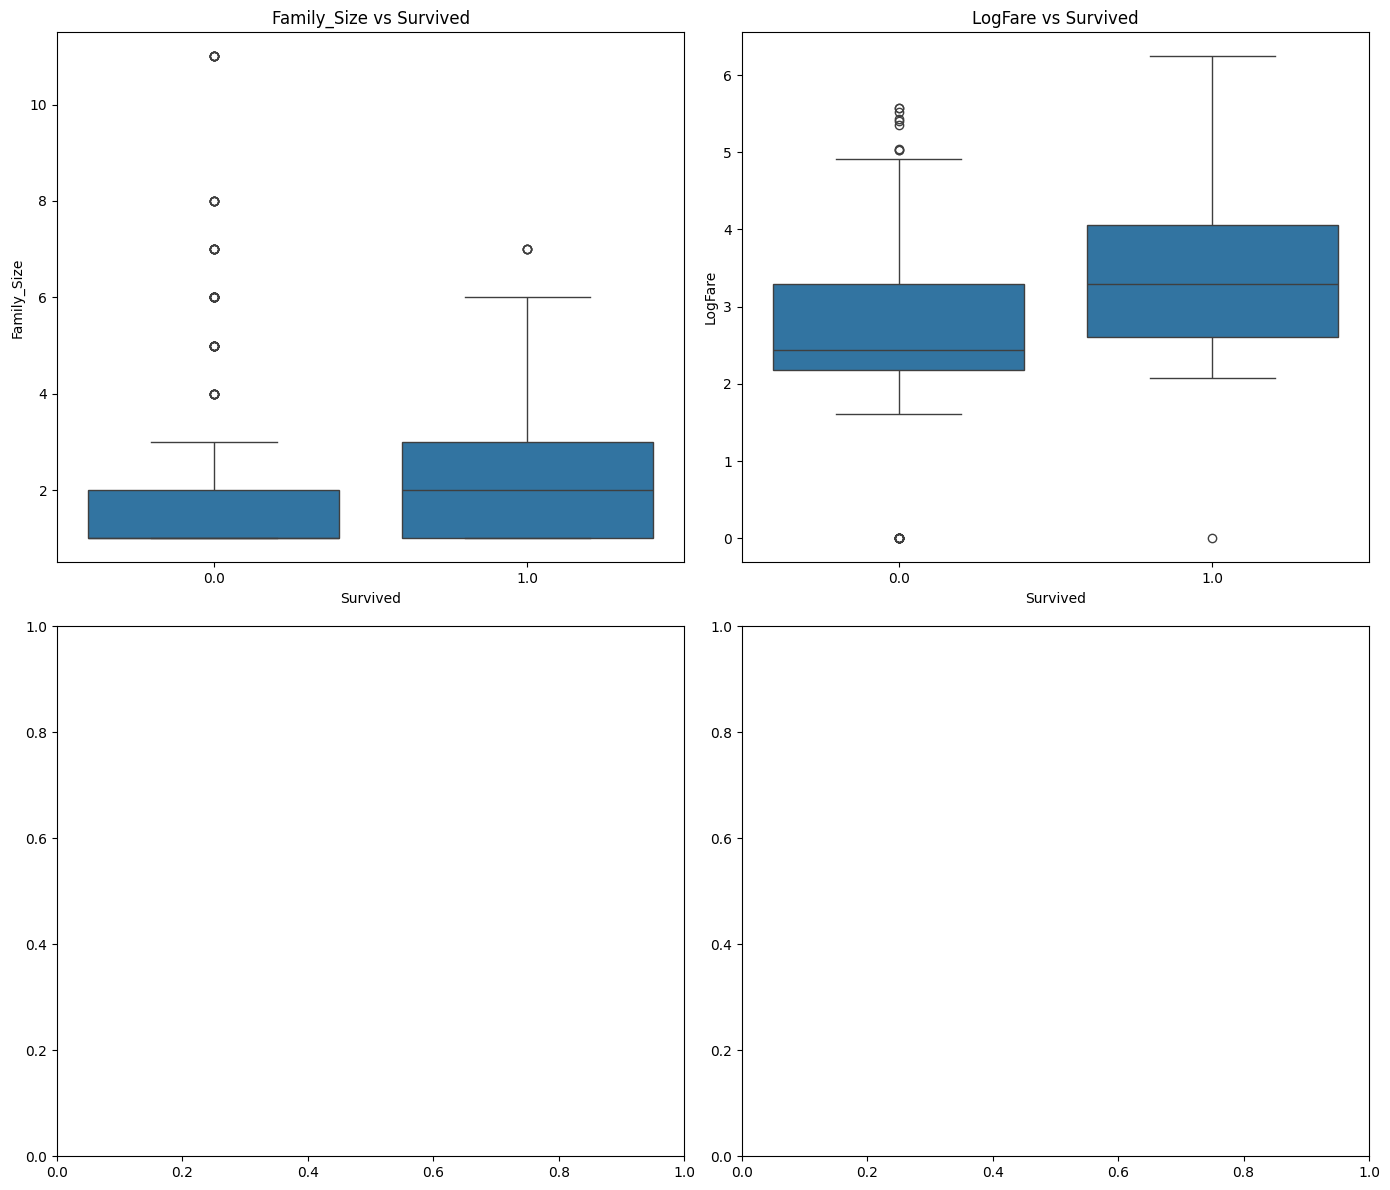

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        sns.boxplot(
            x=target,
            y=feature,
            data=train_df,
            ax=axes[i]
        )
        axes[i].set_title(f"{feature} vs {target}")
        axes[i].set_xlabel(target)
        axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

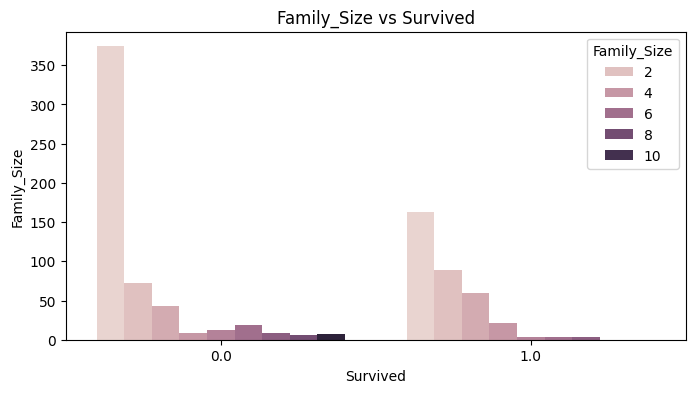

In [8]:
# Countplot for Family_Size
plt.figure(figsize=(8, 4))
sns.countplot(x=target, hue='Family_Size', data=train_df)
plt.title(f'Family_Size vs {target}')
plt.xlabel(target)
plt.ylabel('Family_Size')
plt.show()

## Correlation Analysis
### Numerical features

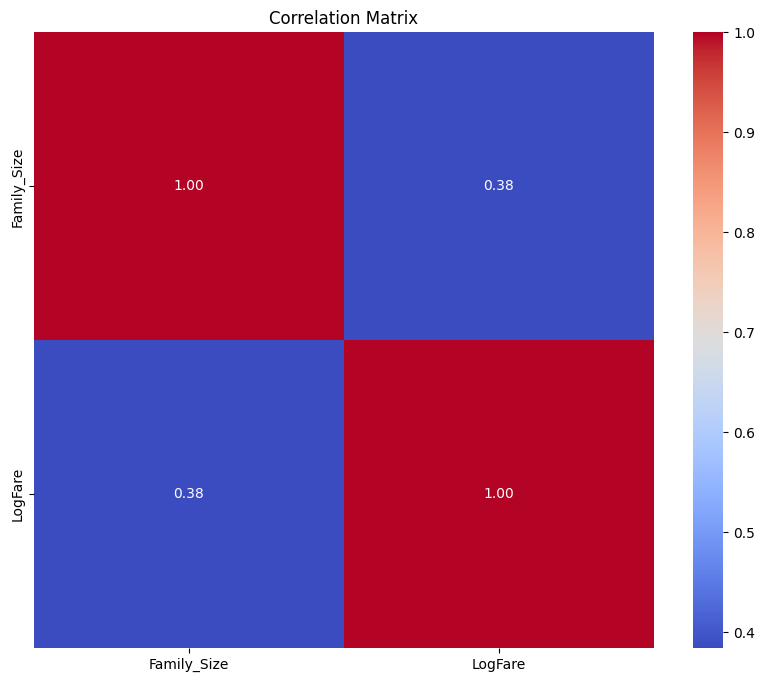

In [9]:
corr = train_df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

             Family_Size  LogFare
Family_Size          1.0      NaN
LogFare              NaN      1.0


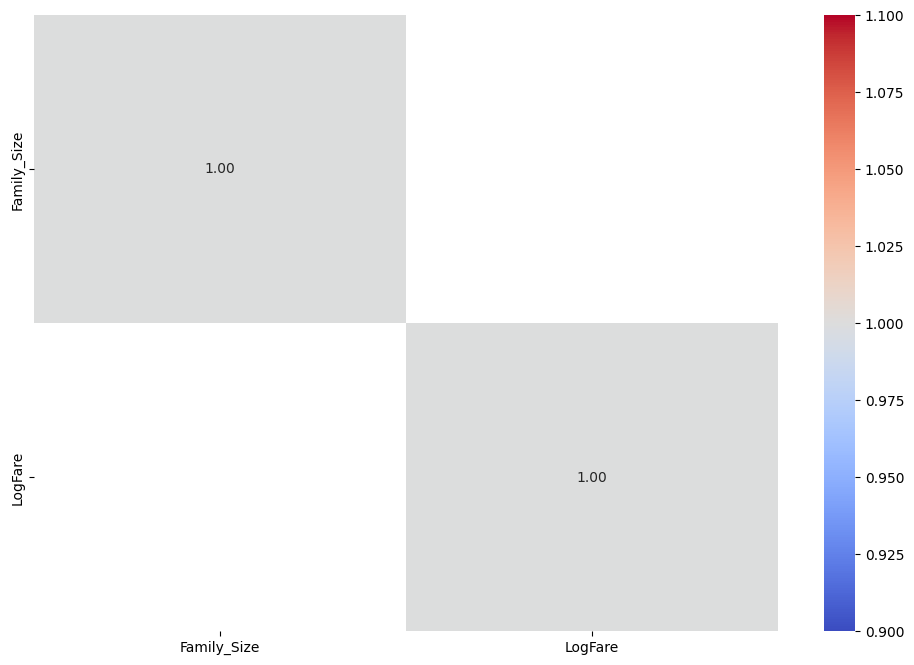

In [10]:
# not useful here, juste to have it in the process:

# Filter the correlation matrix for correlations with an absolute value of at least 0.6
filtered_corr_matrix = corr[(corr.abs() >= 0.6)]

# Drop rows and columns that are entirely NaN (where all correlations were less than 0.6)
filtered_corr_matrix.dropna(how='all', axis=0, inplace=True)
filtered_corr_matrix.dropna(how='all', axis=1, inplace=True)

# Print the filtered correlation matrix
print(filtered_corr_matrix)

# Optional: Visualize the filtered correlation matrix with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Categorical features

In [11]:
from scipy.stats import chi2_contingency

def chi2_test_categorical_features(df, categorical_features, target_col):
    """
    Perform Chi-Square tests between each categorical feature and the target variable.

    Args:
        df (pd.DataFrame): The dataset containing the features and target.
        categorical_features (list): List of categorical feature column names.
        target_col (str): The name of the target column.

    Returns:
        pd.DataFrame: A summary DataFrame with feature names, chi2 statistics, p-values, 
                      and whether the relationship is statistically significant.
    """
    results = []
    for feature in categorical_features:
        contingency_table = pd.crosstab(df[feature], df[target_col])
        
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        
        significant = p < 0.05
        
        results.append({
            'Feature': feature,
            'Chi2_Statistic': chi2,
            'P_Value': p,
            'Significant': significant
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [12]:
results = chi2_test_categorical_features(train_df, categorical_features, target_col=target)
results

,Feature,Chi2_Statistic,P_Value,Significant
0,Pclass,102.888989,4.549252e-23,True
1,Sex,260.717020,1.197357e-58,True
2,Embarked,28.005089,8.294157e-07,True
3,Simplified_Title,6.777604,3.374909e-02,True
4,Deck,99.164161,6.326020e-18,True
5,Is_Alone,36.000514,1.972654e-09,True
6,AgeGroup,13.550294,8.877682e-03,True


In [13]:
from itertools import combinations
from scipy.stats import chi2_contingency

def chi2_all_categorical(df, categorical_features):
    """
    Perform pairwise Chi-Square tests between all categorical variables.

    Args:
        df (pd.DataFrame): The dataset containing the categorical variables.
        categorical_features (list): List of column names representing categorical features.

    Returns:
        pd.DataFrame: A DataFrame summarizing the Chi-Square statistics, p-values, and significance
                      for all variable pairs.
    """
    results = []
    
    for var1, var2 in combinations(categorical_features, 2):
        contingency_table = pd.crosstab(df[var1], df[var2])
        
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        
        significant = p < 0.05
        
        results.append({
            'Variable_1': var1,
            'Variable_2': var2,
            'Chi2_Statistic': chi2,
            'P_Value': p,
            'Significant': significant
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [14]:
results = chi2_all_categorical(train_df, categorical_features)
results

,Variable_1,Variable_2,Chi2_Statistic,P_Value,Significant
0,Pclass,Sex,16.971499,2.063886e-04,True
1,Pclass,Embarked,127.013309,1.694396e-26,True
2,Pclass,Simplified_Title,35.343733,3.948151e-07,True
3,Pclass,Deck,652.408317,1.708918e-128,True
4,Pclass,Is_Alone,16.459030,2.666656e-04,True
5,Pclass,AgeGroup,139.426779,3.122313e-26,True
6,Sex,Embarked,14.244474,8.069595e-04,True
7,Sex,Simplified_Title,30.442513,2.451841e-07,True
8,Sex,Deck,37.643810,8.758898e-06,True
9,Sex,Is_Alone,80.857313,2.426184e-19,True


Let's focus on some features:

In [15]:
def analyze_correlation(df, var1, var2):
    """
    Analyze correlations between levels of two categorical variables using their contingency table.

    Args:
        df (pd.DataFrame): The input DataFrame.
        var1 (str): The first categorical variable.
        var2 (str): The second categorical variable.

    Returns:
        dict: A dictionary containing:
            - 'contingency_table': The observed frequency table.
            - 'expected_frequencies': The expected frequency table.
    """
    contingency_table = pd.crosstab(df[var1], df[var2])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return {
        "contingency_table": contingency_table,
        "expected_frequencies": pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
    }

In [16]:
result = analyze_correlation(train_df, 'Pclass', 'Embarked')

print("Contingency Table (Observed):")
print(result["contingency_table"])
print("\nExpected Frequencies:")
print(result["expected_frequencies"])

Contingency Table (Observed):
Embarked   C   Q    S
Pclass               
1         87   2  127
2         17   3  164
3         66  72  353

Expected Frequencies:
Embarked          C          Q           S
Pclass                                    
1         41.212121  18.666667  156.121212
2         35.106622  15.901235  132.992144
3         93.681257  42.432099  354.886644


In [17]:
result = analyze_correlation(train_df, 'Deck', 'Embarked')

print("Contingency Table (Observed):")
print(result["contingency_table"])
print("\nExpected Frequencies:")
print(result["expected_frequencies"])

Contingency Table (Observed):
Embarked   C   Q    S
Deck                 
A          7   0    8
B         24   0   23
C         21   2   36
D         13   0   20
E          5   1   26
F          1   1   11
G          0   0    4
T          0   0    1
Unknown   99  73  515

Expected Frequencies:
Embarked           C          Q           S
Deck                                       
A           2.861953   1.296296   10.841751
B           8.967452   4.061728   33.970819
C          11.257015   5.098765   42.644220
D           6.296296   2.851852   23.851852
E           6.105499   2.765432   23.129068
F           2.480359   1.123457    9.396184
G           0.763187   0.345679    2.891134
T           0.190797   0.086420    0.722783
Unknown   131.077441  59.370370  496.552189


- It seems that 3rd class passengers are more likely to embark from Southampton, and 1st class passengers are more likely to embark from Cherbourg.
- there is a link between Pclass and Deck but there might be too many categories for a chi2

Let's visualize the correaltions with Creamer's V heatmap:

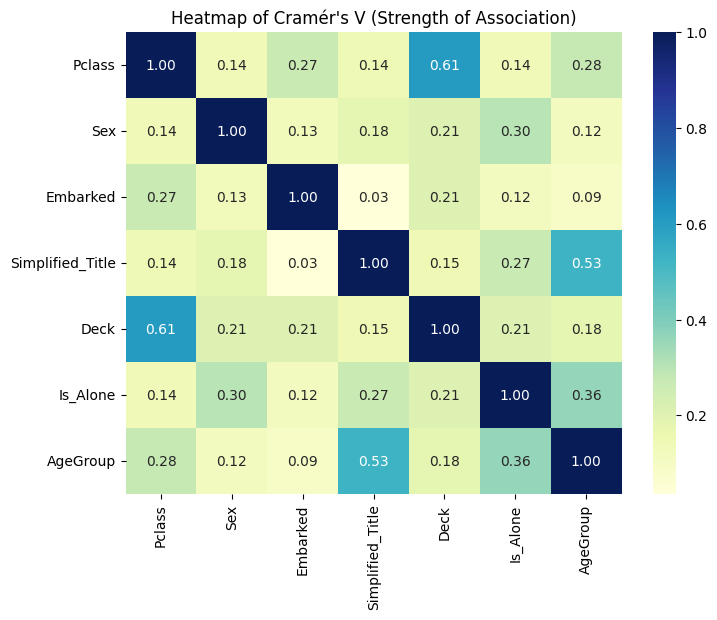

In [18]:
import numpy as np

def cramers_v(x, y):
    """Calculate Cramér's V for two categorical variables."""
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

# Calculate Cramér's V for all pairs of categorical features
cramers_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for var1 in categorical_features:
    for var2 in categorical_features:
        if var1 == var2:
            cramers_v_matrix.loc[var1, var2] = 1.0
        else:
            cramers_v_matrix.loc[var1, var2] = cramers_v(train_df[var1], train_df[var2])

# Convert to float for heatmap compatibility
cramers_v_matrix = cramers_v_matrix.astype(float)

# Plot heatmap of Cramér's V
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Heatmap of Cramér's V (Strength of Association)")
plt.show()

## Train vs Test

### Numerical features

In [19]:
train_summary = train_df[numerical_features].describe()
test_summary = test_df[numerical_features].describe()

print("Train Set Summary Statistics:")
print(train_summary)
print("\nTest Set Summary Statistics:")
print(test_summary)

Train Set Summary Statistics:
       Family_Size     LogFare
count   891.000000  891.000000
mean      1.904602    2.962246
std       1.613459    0.969048
min       1.000000    0.000000
25%       1.000000    2.187218
50%       1.000000    2.737881
75%       2.000000    3.465736
max      11.000000    6.240917

Test Set Summary Statistics:
       Family_Size     LogFare
count   418.000000  418.000000
mean      1.839713    3.014141
std       1.519072    0.967655
min       1.000000    0.000000
25%       1.000000    2.185579
50%       1.000000    2.737881
75%       2.000000    3.480373
max      11.000000    6.240917


In [20]:
from scipy.stats import ks_2samp

# Perform Kolmogorov-Smirnov test for numerical features
for feature in numerical_features:
    ks_stat, p_value = ks_2samp(train_df[feature].dropna(), test_df[feature].dropna())
    print(f"{feature} - KS Statistic: {ks_stat}, P-value: {p_value}")

Family_Size - KS Statistic: 0.021737846299249807, P-value: 0.9988008167693302
LogFare - KS Statistic: 0.03877960895504755, P-value: 0.7667475066503155


### Categorical features

In [21]:
# Function to perform Chi-Square test for a categorical feature
def chi_square_test(train, test, feature):
    train_counts = train[feature].value_counts()
    test_counts = test[feature].value_counts()

    # Combine into a contingency table
    contingency_table = pd.DataFrame([train_counts, test_counts], index=['Train', 'Test']).fillna(0)

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return chi2, p

# Perform Chi-Square tests for each categorical feature
for feature in categorical_features:
    chi2, p = chi_square_test(train_df, test_df, feature)
    print(f"{feature} - Chi-Square: {chi2}, P-value: {p}")

Pclass - Chi-Square: 1.0134212156403517, P-value: 0.6024740965496366
Sex - Chi-Square: 0.111202258413833, P-value: 0.7387795114785529
Embarked - Chi-Square: 7.975616060374664, P-value: 0.018540309410284377
Simplified_Title - Chi-Square: 2.426345081869747, P-value: 0.2972527354486881
Deck - Chi-Square: 5.128030170181437, P-value: 0.7438085726944139
Is_Alone - Chi-Square: 0.0007844079192413937, P-value: 0.9776563421735666
AgeGroup - Chi-Square: 2.2861670187496066, P-value: 0.6832886928427433


- Embarked distributions are not the same between Test and Train.

## Analyses

### Logistic Regression

#### Preprocessing

- Encoding categorical features
- Scaling numerical features
- Train-Test split for validation

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

##### Encoding categorical features

Logistic regression assumes numerical input features, so categorical variables must be transformed into a numerical representation.

If the categorical feature is ordinal (e.g., Education levels: High School, Bachelor’s, Master’s), it can encoded with integers (e.g., 0, 1, 2) to preserve the order.  
If the feature is nominal (e.g., Sex: Male, Female, or Embarked: C, Q, S), one-hot encoding is typically necessary to avoid assigning an arbitrary ordinal relationship between the categories, and then a category needs to be droppeds to avoid dependance and multicolonearity. THe dropped level becomes the baseline.

We can choose the most represented category as the level to drop, as it can reduce overfitting and simplifies interpretation.

In [23]:
def extract_most_represented_levels(df, categorical_features):
    """
    Extract the most represented (most frequent) level for each categorical feature.

    Args:
        df (pd.DataFrame): The input DataFrame.
        categorical_features (list): List of categorical feature names.

    Returns:
        dict: A dictionary where keys are feature names and values are the most represented levels.
    """
    most_represented_levels = {}
    for feature in categorical_features:
        most_represented_level = df[feature].value_counts().idxmax()
        most_represented_levels[feature] = most_represented_level
    return most_represented_levels

In [24]:
most_represented_levels = extract_most_represented_levels(train_df, categorical_features)
print(most_represented_levels)

{'Pclass': '3', 'Sex': 'male', 'Embarked': 'S', 'Simplified_Title': 'Commoner', 'Deck': 'Unknown', 'Is_Alone': '1', 'AgeGroup': 'Adult_20_39'}


In [25]:
def one_hot_encode_drop_most_populated(df, categorical_features, most_represented_levels):
    """
    One-hot encode categorical features and drop the most represented level for each.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        categorical_features (list): List of categorical feature names.
        most_represented_levels (dict): Dictionary of most frequent levels for each feature.
    
    Returns:
        pd.DataFrame: One-hot encoded DataFrame.
    """
    for feature in categorical_features:
        most_frequent = most_represented_levels[feature]
        # One-hot encode and drop the most frequent level
        df = pd.get_dummies(df, columns=[feature], drop_first=False).drop(f"{feature}_{most_frequent}", axis=1)
    return df

In [26]:
encoded_train_df = one_hot_encode_drop_most_populated(train_df, categorical_features, most_represented_levels)

#####  Scaling numerical features

In [30]:
scaler = StandardScaler()
encoded_train_df[numerical_features] = scaler.fit_transform(encoded_train_df[numerical_features])

##### X-y split

In [31]:
X_train = encoded_train_df.drop('Survived', axis=1)
y_train = encoded_train_df['Survived']

#### Model

In [32]:
# Convert boolean columns to integers
X_train = X_train.astype(int)
y_train = y_train.astype(int)

In [34]:
import statsmodels.api as sm

# Add a constant for the intercept
X_train = sm.add_constant(X_train)

In [35]:
# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit(method='bfgs', maxiter=50000)

Optimization terminated successfully.
         Current function value: 0.399286
         Iterations: 191
         Function evaluations: 193
         Gradient evaluations: 193


In [36]:
# Print the summary (includes p-values, coefficients, etc.)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      868
Method:                           MLE   Df Model:                           22
Date:                Sun, 19 Jan 2025   Pseudo R-squ.:                  0.4004
Time:                        11:41:24   Log-Likelihood:                -355.76
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.107e-86
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.4533      0.207    -11.846      0.000      -2.859      -2.047
Family_Size               -0.8831      0.204     -4.319      0.000      -1.284      -0.482
LogF

Significant p-values:

- Family_Size: Negative coefficient (-0.8831). Larger family sizes are associated with lower odds of survival.
- Sex_female: Positive coefficient (3.2184). Being female greatly increases the odds of survival.
- Pclass_1: Positive coefficient (1.6167). First-class passengers had higher survival odds.
- Pclass_2: Positive coefficient (1.0870). Second-class passengers also had higher odds compared to third-class passengers.
- Simplified_Title_Child: Positive coefficient (3.4012). Children had significantly higher odds of survival.
- Deck_E: Positive coefficient (1.5068). Passengers on Deck E had better survival odds.
- AgeGroup_Adult_40_59: Negative coefficient (-0.7511). Adults aged 40–59 were less likely to survive.

In [37]:
odds_ratios = np.exp(result.params)
print(odds_ratios)

const                      0.086011
Family_Size                0.413503
LogFare                    1.464290
Pclass_1                   5.036452
Pclass_2                   2.965500
Sex_female                24.987465
Embarked_C                 1.577074
Embarked_Q                 1.166836
Simplified_Title_Child    30.000021
Simplified_Title_Title     1.250177
Deck_A                     1.994582
Deck_B                     1.947679
Deck_C                     1.218035
Deck_D                     3.140693
Deck_E                     4.512057
Deck_F                     2.051971
Deck_G                     0.563332
Deck_T                     0.000176
Is_Alone_0                 0.706395
AgeGroup_Child             1.345714
AgeGroup_Teenager          0.965388
AgeGroup_Adult_40_59       0.471866
AgeGroup_60+               0.358047
dtype: float64


Checking multicolinearity with VIF:  
High VIF values (>5 or >10) indicate collinearity.

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = X_train.drop('const', axis=1)  # Drop intercept column
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                   feature       VIF
0              Family_Size  1.423800
1                  LogFare  1.612971
2                 Pclass_1  5.715461
3                 Pclass_2  1.351164
4               Sex_female  2.002665
5               Embarked_C  1.381588
6               Embarked_Q  1.103590
7   Simplified_Title_Child  2.434216
8   Simplified_Title_Title  1.140075
9                   Deck_A  1.327750
10                  Deck_B  2.028961
11                  Deck_C  2.299214
12                  Deck_D  1.559073
13                  Deck_E  1.446523
14                  Deck_F  1.046950
15                  Deck_G  1.051659
16                  Deck_T  1.026771
17              Is_Alone_0  2.346683
18          AgeGroup_Child  2.655469
19       AgeGroup_Teenager  1.128182
20    AgeGroup_Adult_40_59  1.461460
21            AgeGroup_60+  1.109253


In [ ]:
# siplified title corrélé avec agegroup (child)
# is aloinf avec family size
# Deck avec Pclass or embarked ?

# refaire en enlevant des features




#### Modeling

In [ ]:
# fit
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_split, y_train_split)

# predict
y_pred = logreg.predict(X_val_split)

# evaluate
print(f'Accuracy: {accuracy_score(y_val_split, y_pred)}')

print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred))

print('Classification Report:')
print(classification_report(y_val_split, y_pred))

##### Hyperparameter Tuning

- C (Inverse of Regularization Strength):
A smaller value of C applies stronger regularization, while a larger value reduces regularization.
Expanding the range to [0.01, 0.1, 1, 10, 100, 1000] helps to explore more potential options for tuning regularization strength.

- penalty:
'l1' (Lasso) and 'l2' (Ridge) are commonly used penalties. By adding 'elasticnet', you can combine both L1 and L2 regularization (note: elasticnet requires the solver='saga').
'none' can be tested for a logistic regression without regularization.

- solver:
'liblinear': Good for small datasets and supports L1 and L2 penalties.
'saga': Supports both L1, L2, and elastic-net penalties, and is well-suited for large datasets.
'lbfgs': Supports L2 and is good for handling large datasets and multinomial classification.
'newton-cg': Works similarly to lbfgs and supports only the L2 penalty.

- class_weight:
Adding 'balanced' helps handle class imbalance by adjusting weights inversely proportional to class frequencies.

- max_iter:
Sometimes logistic regression models fail to converge with lower iteration limits. Testing a broader range of values ensures that your model is given enough iterations to converge.

In [ ]:
param_grid = {
    'C': [10**(i) for i in range(-4, 3)],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  # Added compatible solvers
    'max_iter': [5000, 10000, 50000]
}

grid_search = GridSearchCV(LogisticRegression(max_iter=50000), param_grid, cv=5, verbose=1, error_score='raise')
grid_search.fit(X_train_split, y_train_split)

In [ ]:
print(f'Best Parameters: {grid_search.best_params_}')

In [ ]:
logreg_final = LogisticRegression(max_iter=5000, C=10, penalty='l2', solver='liblinear')
logreg_final.fit(X_train, y_train)

# Predict on the test set
y_pred_final = logreg_final.predict(X_val_split)

# evaluate
print(f'Accuracy: {accuracy_score(y_val_split, y_pred_final)}')

print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred_final))

print('Classification Report:')
print(classification_report(y_val_split, y_pred_final))

Interpretability

In [ ]:
# Coefficients 
coefficients = logreg_final.coef_[0]  

# Pair the feature names with their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Sort by the absolute value of the coefficient (optional)
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

print(feature_importance)

In [ ]:
# Visualize the feature importance using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Logistic Regression Feature Importance (Coefficients)')
plt.show()

P-values  
The pvalues are not provided with sklearn, we would need to use statsmodels.

In [234]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

In [ ]:
# Convert all boolean columns to integers (0, 1)
X_train = X_train.astype(int)
y_train = y_train.astype(int)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Create a DataFrame for X_train_scaled with the original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Add a constant for the intercept
X_train_scaled_df = sm.add_constant(X_train_scaled_df)

# Fit the logistic regression model using the DataFrame with named columns
logit_model = sm.Logit(y_train, X_train_scaled_df)
result = logit_model.fit(method='bfgs', maxiter=50000)

# Print the summary (includes p-values, coefficients, etc.)
print(result.summary())

f1 score : 82%  
variables qui influent significativement sur la survie : Age, Pclass_3, Sexe_male, Title, SibSp, Parch.  
variables significatives sont differentes des feature importantes pour la classification.
car la reg logistique capture bien les relations linéaires, les effes d'une variables qd les autres sont constantes, mais pas les relations complexes.

In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go

# Apply PCA to reduce the features to 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_split_pca = pca.transform(X_val_split)

# Get the percentage of variance explained by each component
explained_variance = pca.explained_variance_ratio_ * 100

# Train the logistic regression model on PCA-transformed data
logreg_final_pca = LogisticRegression(max_iter=5000, C=10, penalty='l2', solver='liblinear')
logreg_final_pca.fit(X_train_pca, y_train)

# Generate mesh grid for PCA space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the grid
Z = logreg_final_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create contour plot for decision boundary
contour = go.Contour(
    z=Z,
    x=np.arange(x_min, x_max, 0.1),
    y=np.arange(y_min, y_max, 0.1),
    colorscale='Viridis',
    opacity=0.7,
    showscale=False,
)

# Plot the training points in PCA space
scatter = go.Scatter(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    mode='markers',
    marker=dict(
        color=y_train,
        colorscale='Portland',
        line=dict(width=1, color='black'),
        size=8
    ),
    text=['Survived: {}'.format(s) for s in y_train]
)

# Set layout for the plot, including percentage of explained variance in axis labels
layout = go.Layout(
    title="Logistic Regression Decision Boundary (PCA Projection)",
    xaxis=dict(title=f"PCA Component 1 ({explained_variance[0]:.2f}% variance explained)"),
    yaxis=dict(title=f"PCA Component 2 ({explained_variance[1]:.2f}% variance explained)"),
    hovermode='closest',
    showlegend=False
)

# Combine contour and scatter plots
fig = go.Figure(data=[contour, scatter], layout=layout)

# Show the plot
fig.show()


### Random Forest

Preprocessing

- Missing values : already dealt with
- One hot encoding
- feature scaling : not necessary
- Train-Test split

In [237]:
from sklearn.ensemble import RandomForestClassifier

In [238]:
# One-hot encode categorical features for train and test sets
encoded_train_df = one_hot_enc_choose_cat(train_df)
encoded_test_df = one_hot_enc_choose_cat(test_df)

# Split the target and features in the training data
X_train = encoded_train_df.drop(columns=['Survived'])
y_train = encoded_train_df['Survived']

X_test = encoded_test_df

# Split the training data into a train and validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Modelling

In [239]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_pred = rf_model.predict(X_val_split)

In [ ]:
# Evaluate the model
print(f'Accuracy: {accuracy_score(y_val_split, y_pred)}')
print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred))
print('Classification Report:')
print(classification_report(y_val_split, y_pred))

Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Predict on the validation set using the best model
y_pred_best = best_rf_model.predict(X_val_split)

In [ ]:
# Evaluate the tuned model
print(f'Accuracy after tuning: {accuracy_score(y_val_split, y_pred_best)}')
print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred_best))
print('Classification Report:')
print(classification_report(y_val_split, y_pred_best))

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search.best_params_}')

Interpretability

Feature importance

In [ ]:
# Get feature importance
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest Model')
plt.show()

### XGBoost

Preprocessing

- Missing values: already delt with
- One hot encoding
- featuyre scaling ?
- Train-test split

In [244]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [245]:
# One-hot encode categorical features for train and test sets
encoded_train_df = one_hot_enc_choose_cat(train_df)
encoded_test_df = one_hot_enc_choose_cat(test_df)

# Split the target and features in the training data
X_train = encoded_train_df.drop(columns=['Survived'])
y_train = encoded_train_df['Survived']

X_test = encoded_test_df

# Split the training data into a train and validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ensure the target variable is numeric (integer)
y_train_split = y_train_split.astype(int)
y_val_split = y_val_split.astype(int)


In [246]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_pred = xgb_model.predict(X_val_split)

In [ ]:
# Evaluate the model
print(f'Accuracy: {accuracy_score(y_val_split, y_pred)}')
print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred))
print('Classification Report:')
print(classification_report(y_val_split, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Predict on the validation set using the best model
y_pred_best = best_xgb_model.predict(X_val_split)

# Evaluate the tuned model
print(f'Accuracy after tuning: {accuracy_score(y_val_split, y_pred_best)}')
print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred_best))
print('Classification Report:')
print(classification_report(y_val_split, y_pred_best))

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search.best_params_}')


Interpretability

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the best model
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame for the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('XGBoost Feature Importance')
plt.show()


### KNN

Preprocessing

- Missing values: already delt with
- One hot encoding
- scaling
- Train-test split 

In [250]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [251]:
# One-hot encode categorical features using your existing function
encoded_train_df = one_hot_enc_choose_cat(train_df)
encoded_test_df = one_hot_enc_choose_cat(test_df)

# Scaling the features
scaler = StandardScaler()
encoded_train_df[numerical_features] = scaler.fit_transform(encoded_train_df[numerical_features])
encoded_test_df[numerical_features] = scaler.transform(encoded_test_df[numerical_features])


# Split the target and features in the training data
X_train = encoded_train_df.drop(columns=['Survived'])
y_train = encoded_train_df['Survived'].astype(int)  # Ensure the target is an integer


In [ ]:
# Split the training data into a train and validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn_model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_pred = knn_model.predict(X_val_split)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_val_split, y_pred)}')
print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred))
print('Classification Report:')
print(classification_report(y_val_split, y_pred))

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],  # Consider uniform or distance-based weighting
    'metric': ['euclidean', 'manhattan']  # Different distance metrics
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

# Get the best model
best_knn_model = grid_search.best_estimator_

# Predict on the validation set using the best model
y_pred_best = best_knn_model.predict(X_val_split)

# Evaluate the tuned model
print(f'Accuracy after tuning: {accuracy_score(y_val_split, y_pred_best)}')
print('Confusion Matrix:')
print(confusion_matrix(y_val_split, y_pred_best))
print('Classification Report:')
print(classification_report(y_val_split, y_pred_best))

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search.best_params_}')

Interpretability

In [ ]:
import lime
import lime.lime_tabular

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_split, feature_names=X_train.columns, class_names=['Died', 'Survived'], discretize_continuous=True)

# Select a single instance from the validation set
instance = X_val_split[0].reshape(1, -1)

# Generate explanation for that instance
exp = explainer.explain_instance(instance.flatten(), best_knn_model.predict_proba)
exp.show_in_notebook(show_all=False)

ameliorer le tuning, + ecrire une synthese de ce que fait chaque technique.

Comparer les perf de chaque modele, et les feature importance.
puis choisir le meilleur pour la soumission.

### Clustering ?  

Pour trouver plus d'info sur les features qui separe les groupes, ou comment les groupes sont séparés.

voir SHAP values, ROC curves, + d'hypermarameter tuning